# **ENN: Expressive Neural Network (with LMS for backpropagation)**

### **1. Introduction**

This notebook provides an implementation of the [Expressive Neural Network (ENN)](https://arxiv.org/abs/2307.00673) with Numpy. Particularly, we provide a standard least mean squares (LMS) algorithm for backpropagation. We empirically show that LMS outperforms state-of-the-art frameworks, such as Adam. Visit [ENN in Pytorch](https://colab.research.google.com/drive/1S70GaGfkSLipH_byNqAPnknESNzp5h_y?usp=sharing) for an implementation of the ENN in Pytorch.

The ENN is a multilayer perceptron with adaptive activation functions (AAF). What makes the ENN expressive and interpretable is that these nonlinear AAF are modeled with the discrete cosine transform (DCT). The coefficients of the DCT are learnt during backpropagation. The ENN is the first neural network model that relies on signal processing techniques.

The notebook is divided into the following sections:
1.   Introduction.
2.   Libraries and datasets.
3.   Why use the DCT?
4.   ENN model.
5.   Performance.


### **2. Libraries and datasets**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
import matplotlib.colors
from scipy.fftpack import dct, idct

In [2]:
def MSE_loss(a, b, norm=False):
    """
    This function computes the MSE between to arrays.

    Parameters
    ----------
    a, b : ndarray
        Input arrays. The first one is the reference that will be used to
        normalize the MSE.
    norm: boolean
        If True, the MSE is normalized by the power of the array a.

    Returns
    -------
    real
        The MSE between the two arrays.
    """
    MSE = ((a-b)**2).mean()
    MSE_norm = MSE/np.sum(a**2)
    return MSE_norm if norm else MSE

def truncate(v, M):
    """
    This function truncates a vector up to the M largest components. The rest
    (length(v)-M) are set to 0.

    Parameters
    ----------
    v : ndarray
        Input array.
    M : int
        Number of largest components to maintain.

    Returns
    -------
    v : ndarray
        Output array.
    M_pos : ndarray
        Indeces of non-zero kept entries.
    """
    v = v.copy()
    idx = np.argsort(-abs(v))
    v[idx[M:]] = 0
    M_pos = np.nonzero(v)[0]
    return v, M_pos

The goal of these experiments is to show the ability of the ENN to represent complex nonlinear functions in a supervised setting. For this reason, we do not work with standard machine learning datasets (e.g., MNIST), but with synthetic data. Using traditional datasets hinders the analysis due to the existence of other issues (e.g., dataset distribution). We further constrain the analysis to two input variables, which eases the interpretability of the results. Nonetheless, it does not prevent from extending the ENN to multiple input variables.

In the following we provide a wide variety of binary functions:
*   **Classification problems:** these are linear, quadratic, cubic and higher-order binary classification problems.
*   **Regression problems:** we provide the sum, norm and product.





In [3]:
class Dataset:
  def __init__(self, n_samples, function):
    self.n_samples = n_samples
    self.function = function
    self.x = 2*( np.random.rand(2,n_samples) -0.5*np.ones((2,n_samples)) )

    #Classification problems
    if function == 1: # Linear discriminant
        y = -np.ones(n_samples)
        a = -0.4
        b = -0.3
        pos = self.x[0,:] < a*self.x[1,:] + b
        y[pos] = 1
        self.y = y
        self.category = 'classification'

    elif function == 2: # Linear discriminant
        y = -np.ones(n_samples)
        a = 2
        b = 0.5
        pos = self.x[0,:] < a*self.x[1,:] + b
        y[pos] = 1
        self.y = y
        self.category = 'classification'

    elif function == 3: # Linear discriminant
        y = -np.ones(n_samples)
        a=1
        b=0
        pos = self.x[0,:] < a*self.x[1,:] + b
        y[pos] = 1
        self.y = y
        self.category = 'classification'

    elif function == 4: # Linear discriminant
        y = -np.ones(n_samples)
        a = 0
        b = 0
        pos = self.x[0,:] < a*self.x[1,:] + b
        y[pos] = 1
        self.y = y
        self.category = 'classification'

    elif function == 5: # Ring
        y = -np.ones(n_samples)
        rad_out = 0.65
        rad_in = 0.3
        shift_in = np.array([[0,0]]).T
        pos = (np.linalg.norm(self.x, axis=0) < rad_out) & (np.linalg.norm(self.x-shift_in, axis=0) > rad_in)
        y[pos] = 1
        self.y = y
        self.category = 'classification'

    elif function == 6: # Quadratic discriminant
        y = -np.ones(n_samples)
        a = 0.3
        b = -0.2
        c = 0.1
        pos = self.x[0,:] < a*self.x[1,:]**2 + b*self.x[1,:] + c
        y[pos] = 1
        self.y = y
        self.category = 'classification'

    elif function == 7: # Cubic discriminant
        y = -np.ones(n_samples)
        a = -0.3
        b = 0.2
        c = 0.0
        d = 0.1
        pos = self.x[0,:] < a*(self.x[1,:]**3) + b*(self.x[1,:]**2) + c*(self.x[1,:]**2) + d
        y[pos] = 1
        self.y = y
        self.category = 'classification'

    elif function == 8: # Stripes
        y = -np.ones(n_samples)
        pos = self.x[0,:] < 300*np.sin( 10*(self.x[1,:]+0.15) )
        y[pos] = 1
        self.y = y
        self.category = 'classification'

    elif function == 9: # Sine
        y = -np.ones(n_samples)
        pos = self.x[0,:] < np.sqrt(0.5)*np.sin( 10*(self.x[1,:]+0.15) )
        y[pos] = 1
        self.y = y
        self.category = 'classification'

    elif function == 10: # Cirlce and ellipse
        y = -np.ones(n_samples)
        rad_in = 0.35
        cen_1 = np.array([[0.3,0.45]]).T
        cen_2 = np.array([[-0.3,-0.4]]).T
        exce = np.array([[2,1]]).T
        pos = (np.linalg.norm((self.x-cen_1)/exce, axis=0) < rad_in) | (np.linalg.norm(self.x-cen_2, axis=0) < rad_in)
        y[pos] = 1
        self.y = y
        self.category = 'classification'

    elif function == 11: # Face
        y = -np.ones(n_samples)
        rad_out = 0.65
        rad_in = 0.3
        shift_out = np.array([[0,-0.2]]).T
        shift_in = np.array([[0,-0.2]]).T
        cir_l = np.array([[-0.35,0.7]]).T
        cir_r = np.array([[0.35,0.7]]).T
        rad_circ = 0.2
        pos_ring = (np.linalg.norm(self.x-shift_out, axis=0) < rad_out) & (np.linalg.norm(self.x-shift_in, axis=0) > rad_in)
        pos_circ = (np.linalg.norm(self.x-cir_l, axis=0) < rad_circ) | (np.linalg.norm(self.x-cir_r, axis=0) < rad_circ)
        y[pos_ring | pos_circ] = 1
        self.y = y
        self.category = 'classification'

    elif function == 12: # High-frequency sine
        y = -np.ones(n_samples)
        pos = self.x[0,:] < np.sqrt(0.005)*np.sin( 30*(self.x[1,:]+0.15) )
        y[pos] = 1
        self.y = y
        self.category = 'classification'


    #Regression problems
    elif function == 12: # Sum
        y = np.sum(self.x, axis=0)/2
        self.y = y
        self.category = 'regression'

    elif function == 13: # Norm
        y = np.linalg.norm(self.x, axis=0)**2/2
        self.y = y
        self.category = 'regression'

    elif function == 14: # Product
        y = np.prod(self.x, axis=0)
        self.y = y
        self.category = 'regression'

The following code shows how to create a dataset and visualize it.

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


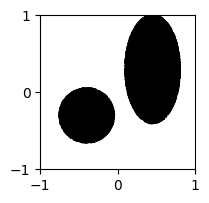

In [4]:
function = 10 # Visualize only classification functions, i.e., function in [1,11]
samples = 100000 #The more samples, the better the visualization
dataset = Dataset(samples, function)

fig = plt.figure( figsize=(2,2) )
plt.scatter(dataset.x[1,:], dataset.x[0,:], dataset.y, 'k')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
plt.show()

### **3. Why use the DCT?**

Assume a set of function values $y_n$ for $n=0,\dots, N-1$.

We will use the following definition for the Discrete Cosine Transform (DCT), which corresponds to the Type-II DCT:
\begin{equation}
Y_k = f_k\sum_{n=0}^{N-1} y_n \cos\left(\frac{\pi k(2n+1)}{2N}\right)\quad \text{for} \quad k=0,\dots, N-1
\end{equation}

where $f_k=1/\sqrt N$ for $k=0$ and $f_k=\sqrt{2/N}$ otherwise. The $y_n$ are each one of the function values and $Y_k$ are termed the DCT coefficients.

Regarding the inverse DCT (iDCT), we use the definition provided by the orthonormal Type-III DCT:
\begin{equation}
y_n = \sum_{k=0}^{N-1} f_kY_k \cos\left(\frac{\pi (2n+1)k}{2N}\right)\quad \text{for} \quad n=0,\dots, N-1
\end{equation}

To understand the relationship between the discrete Fourier transform (DFT) and the DCT, we compute the three following transformations over a sigmoid function:
*   DFT of the sigmoid function.
*   DCT of the sigmoid function.
*   DFT of the sigmoid function, which has previously been extended to have even symmetry.

In fact, the last two computations are equivalent. This is, the DCT takes a function and extends it to have even symmetry. Then, the FFT is computed over this new function. As seen below, the DFT coefficients of the extended function are equivalent to the DCT coefficients. In fact, by doing so, the resolution of the DCT is doubled with respect to the DCT.

Note that the x-axis does not correspond to time, as it usually happens with Fourier transformations. In here, the x-axis is the domain of the function.

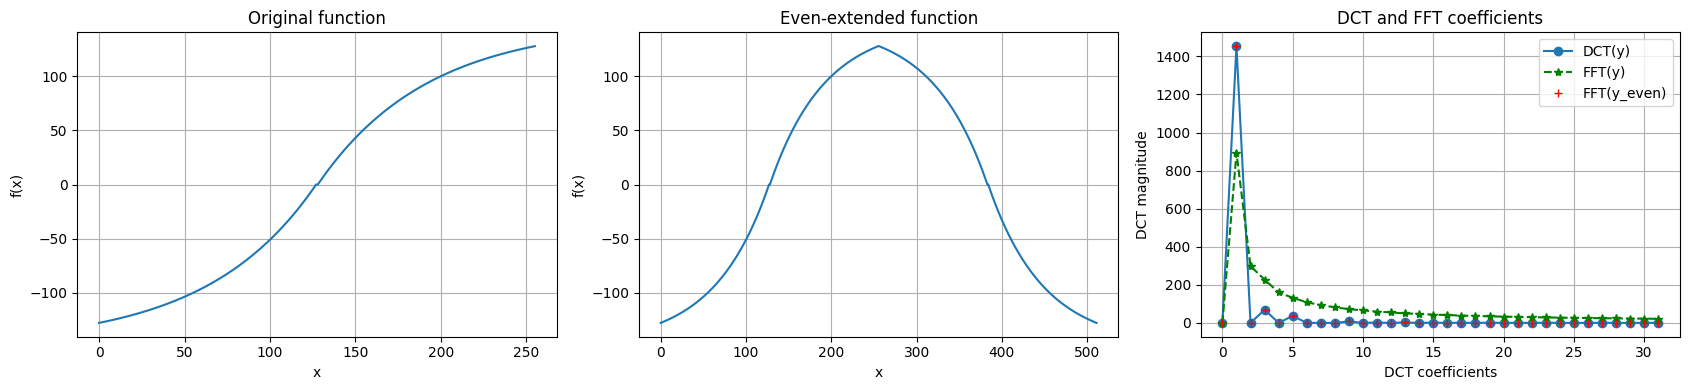

In [5]:
N = 256
x = np.arange(1, N+1)
mu = -0.5 * N/2
y_left = (N/2) * ( 1 - np.exp( -(1/mu)*x[:int(N/2)] )) / ( 1 - np.exp( -N/(2*mu) ))
y_right = np.flip(-y_left) + N
y = np.hstack(( y_left, y_right )) - N/2
y_even = np.hstack(( y, np.flip(y) ))

Y_dct = dct(y, norm='ortho')
Y_fft = np.fft.fft(y, norm='ortho')
Y_even_fft = np.fft.fft(y_even, norm='ortho')


# Plots #######################################################################
fig, ax = plt.subplots(1, 3, figsize=(17,4))
ax[0].plot(y, '-')
ax[0].set(xlabel='x', ylabel='f(x)')
ax[0].set_title('Original function')
ax[0].grid()

ax[1].plot(y_even, '-')
ax[1].set(xlabel='x', ylabel='f(x)')
ax[1].set_title('Even-extended function')
ax[1].grid()

ax[2].plot(abs(Y_dct[0:32]), 'o-')
ax[2].plot(abs(Y_fft[0:32]), 'g--*')
ax[2].plot(abs(Y_even_fft[0:32]), 'r+')
ax[2].legend(['DCT(y)', 'FFT(y)', 'FFT(y_even)'])
ax[2].set(xlabel='DCT coefficients', ylabel='DCT magnitude')
ax[2].set_title('DCT and FFT coefficients')
ax[2].grid()
fig.tight_layout()

The results are evident: the DCT achieves a large compression. In the following we show the MSE that the DCT achieves and the relationship with respect to its coefficients. This will be exemplified with a different compressor function.

The energy (in %) retained by the DCT approximation is
\begin{equation}
\alpha = \frac{\sum_{m=1}^{M}Y_m^2}{\sum_{m=1}^{N}Y_m^2},
\end{equation}
where $M$ is the number of preserved coefficients. Since the DCT basis (i.e., the cosines) are orthogonal, the preserved energy corresponds to the fraction of energy retained in the coefficients.

Furthermore, the normalized mean squared error (NMSE) that the approximation achieves with $M$ coefficients corresponds to
\begin{equation}
NMSE = \frac{1}{N}\frac{\sum_{m=M+1}^{N}Y_m^2}{\sum_{m=1}^{N}Y_m^2}=
\frac{1-\alpha}{N},
\end{equation}
which is no more the energy preserved in the disregarded coefficients.

Then, the DCT will be a good model as long as it preserves the required coefficients. Luckily, the DCT coefficients for smooth functions with odd symmetry (as the ones considered in these examples) are ordered in decreasing magnitude. Furthermore, notice that only the odd coefficients are different from zero and ordered in decreasing order. The latter happens due to the odd symmetry of the function.

This is what makes the DCT a good model for function approximation: The transformation is highly interpretable and the performance with respect to the coefficients is well defined. In practice, we will constrain the DCT model to have only odd coefficients. While this constraints the nonlinear activation function to be odd, this does not constrain the multilayer perceptron from learning non-odd functions. This assumption also eases building the model for function approximation, because the coefficients are real and ordered in decreasing order. Thus, the only hyperparameter that the ENN will need to manage with respect to the nonlinear activation function is the number of preserved coefficients, $M$. In practice we see that more than $M=6$ coefficients is not needed. Then, $M$ can be fixed from the start.




Energy retained:  0.9973546928415632
MSE_norm:  1.0333231087643195e-05 1.0333231087643769e-05


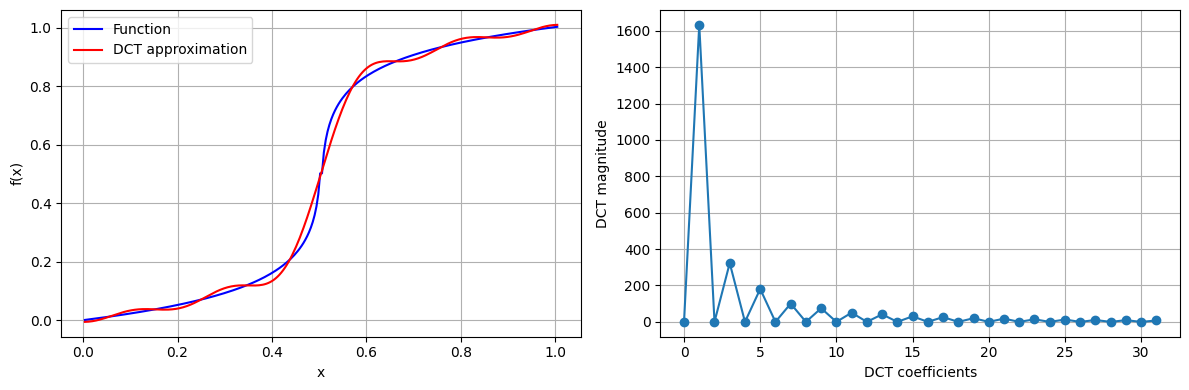

In [6]:
N = 256
x = np.arange(1,N+1)
y_right = np.log(x[:int(N/2)])
y = (N/2)/np.log(x[int(N/2)]) * np.hstack(( np.flip(-y_right), y_right ))

M = 5 #Change this parameter from 1 to 256
Y_dct = dct(y, norm='ortho')
Y_dct_trunc, M_pos = truncate(Y_dct, M)
y_aprox = idct(Y_dct_trunc, norm='ortho')

alpha = np.sum(Y_dct_trunc**2) / np.sum(Y_dct**2)
MSE = MSE_loss(y, y_aprox, norm=True)
print('Energy retained: ', alpha)
print('MSE_norm: ', MSE, (1-alpha)/N)

# Plots #######################################################################
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(x/255,  (y+128)/255, 'b')
ax[0].plot(x/255, (y_aprox+128)/255, 'r')
ax[0].set(xlabel='x', ylabel='f(x)')
ax[0].legend(['Function', 'DCT approximation'])
ax[0].grid()

ax[1].plot(abs(Y_dct[0:32]), 'o-')
ax[1].set(xlabel='DCT coefficients', ylabel='DCT magnitude')
ax[1].grid()

fig.tight_layout()

### **4. ENN model**

We construct a multilayer perceptron with 2 inputs, a single hidden layer and an output neuron. The ENN contains the following input parameters:
*   `n_input`: number of inputs (i.e., 2).
*   `width`: number of hidden neurons.
*   `nft`: number of DCT samples to represented each AAF.
*   `n_coeffs`: number of DCT coefficients to represent each AAF  (in practice, no more than 6 are required).

Besides, the ENN generates the following parameters:
*   `W_hid`: matrix of linear weights in the hidden layer.
*   `F_hid`: matrix of DCT coefficients in the hidden layer.
*   `Q_hid`: matrix of DCT indeces in the hidden layer.
*   `W_out`: matrix of linear weights in the output layer.
*   `F_out`: matrix of DCT coefficients in the output layer.
*   `Q_out`: matrix of DCT indeces in the output layer.
*   `p_hid`: vector of power magnitudes in the hidden layer.
*   `p_out`: vector of power magnitudes in the output layer.

For instance, ```F_hid[:,i]``` contains the coefficients of the i-th neuron in the hidden layer. ```Q``` matrices are constant, since the indeces of the coefficients are odd numbers from 1 to ```2*n_coeffs-1```. The power terms are used to normalize the gradient step with respect to the input.

---
While all AAF are initialized to lines, linear weights are initialized to provide bump diversity. Bump diversity refers to the fact that the AAF are oriented in different directions with respect to the output two-dimensional space. For instance, with `hidden_dim=2`, the linear weights in the hidden layer are initialized so that one AAF lays on the x-axis, and the other one in the y-axis. Intuitively, this speeds up convergence by providing diversity in as many different directions as possible. Check the paper for a detailed explanation on this topic.

---

The ENN is trained and tested with ```train()``` and ```train()```, respectively. The backpropagation is implemented with least mean squares (LMS) and expressed in a closed-form solution. This is possible because the derivative of the cosine function is always defined.

We define `out_fc1` as the output of the linear weights in the hidden layer. The AAF computes the following:
$$
\text{hid_out} = \sum_{q=1}^{Q/2}F_q\cos\left(\frac{\pi(2q-1)(2\bar{x}+1)}{2\text{N}}\right),
$$

where $\bar{x}=\frac{N}{2}(\text{out_fc1}+1)$ and $N$ is the number of nft points (i.e., `nft`).

---

In Section 3 we have discussed the benefits of the DCT with respect to function approximation. In general, the DCT is a model that it is much easier to interpret and tune than other function approximations. From the perspective of learning, however, the DCT provides other advantages: in backpropagation, the derivative of the cosine is a sine, which is bounded. Then, the DCT does not experience exploding gradients. Furthermore, there are closed-form expressions for the gradient, which are not feasible with other approximation models.



In [7]:
class ENN:
    def __init__(self, n_input, width, nft, n_coeffs):
        self.n_input = n_input
        self.width = width
        self.nft = nft
        self.n_coeffs = n_coeffs

        # DCT coefficients and indeces. The same for all neurons.
        idx = np.arange(2, 2*n_coeffs+1, 2)
        coeffs = (2/nft) * np.array([-207.6068,-23.1526,-8.3292,-4.2629,-2.5883,-1.5147])[:n_coeffs]    # AAF are initialized as lines
        self.F_hid = np.tile(coeffs,(width,1)).T                                                        # F_hid.shape=(n_coeffs,width) with F_hid[:,i] as the non-linear coeffs of the i-th neuron in the hidden layer
        self.Q_hid = np.tile(idx, (width,1)).T                                                          # Q_hid.shape=(n_coeffs,width) with Q_hid[:,i] as the indeces of the non-linear coeffs of the i-th neuron in the hidden layer
        self.F_out = coeffs[...,None]                                                                   # F_out.shape=(n_coeffs,1) with a unique neuron at the output layer
        self.Q_out = idx[...,None]                                                                      # Q_out.shape=(n_coeffs,1) with a unique neuron at the output layer

        # Random or deterministic initial coefficientes in the linear layer
        self.W_hid = np.zeros((n_input+1,width))                                                        # W_hid.shape=(n_input+1,width) with W_hid[:,i] as the linear weights of the i-th neuron in the hidden layer
        gam = 0.5                                                                                       # Define intial dynamic range
        rad = 2*np.pi/(2*width)
        for i in range(width):
            self.W_hid[:,i] = gam * np.array([0, np.cos(i*rad), np.sin(i*rad)], ndmin=2)

        self.W_out = np.zeros((width+1,1))                                                              # W.shape=(width+1,1) with only one neuron at the output layer
        self.W_out[1::2] = 1
        self.W_out[2::2] = -1
        if width%2==1:
            self.W_out[-2:] = -0.5
        self.W_out = gam * self.W_out

        # Power used to normalize the gradient step (set to 1)
        self.p_out = 1
        self.p_hid = np.ones((1,width))                                                                 # p_hid.shape=(1,width) with W_hid[0,i] as the linear power of the i-th neuron in the hidden layer


    def train(self, data, lms, verbose=False):
        x = data.x
        y = data.y
        n_samples = x.shape[1]
        width = self.width
        loss = np.zeros(n_samples)

        print('Training ENN...')
        for i in range(n_samples):
            print('Sample', i,'/',n_samples) if i%(n_samples/5)==0 and verbose else 0
            _, loss[i], x_proc = self.forward(x[:,[i]], y[i])
            self.backprop(x[:,[i]], x_proc, loss[i], lms)

        return loss


    def test(self, data, verbose=False):
        x = data.x
        y = data.y
        n_samples = x.shape[1]
        y_pred = np.zeros(n_samples)
        error = np.zeros(n_samples)

        print('Testing ENN...')
        for i in range(n_samples):
            print('Sample', i,'/',n_samples) if i%(n_samples/5)==0 and verbose else 0
            y_pred[i], error[i], _ = self.forward(x[:,[i]], y[i])

        if data.category=="classification": # Accuracy
            y_hard = np.ones(n_samples)
            y_hard[y_pred<0] = -1
            acc = 100 * np.sum((y-y_hard)!=0)/n_samples
            return y_hard, error, acc

        else: # Regression, MSE
            mse = np.mean(error**2)
            return y_pred, error, mse


    def forward(self, x_batch, y_batch):
        x_proc, _ = self.process_layer(x_batch)
        y_pred, error = self.process_layer(x_proc, y_batch)
        return y_pred, error, x_proc


    def backprop(self, x_batch, x_proc, loss, lms):
        self.F_out, self.W_out, grad, self.p_out = self.learn_layer(x_proc, loss, np.zeros(self.width), lms.alpha_F_out, lms.alpha_W_out, 1, lms.beta)
        self.F_hid, self.W_hid, _, self.p_hid = self.learn_layer(x_batch, loss, grad[1:,:].T, lms.alpha_F_hid, lms.alpha_W_hid, 1, lms.beta)


    def process_layer(self, x_batch, y_batch=float('NaN')):
        if np.isnan(y_batch): # Hidden layer
            W = self.W_hid
            F = self.F_hid
            Q = self.Q_hid
        else: #Output layer
            W = self.W_out
            F = self.F_out
            Q = self.Q_out

        # Linear layer
        xg = W[[0],:].T + W[1:,:].T @ x_batch                                                           # shape=(6,1)

        # Nonlinear layer (DCT)
        xuso = ((xg + 1) / 2) * self.nft
        xsna = np.cos( (np.pi / (2 * self.nft)) * (Q-1).T * (2*xuso-1) ).T                              # shape=(6,6) with xsna[:,i] as the cosines for the i-th neuron
        y_pred = np.sum(F*xsna, 0, keepdims=True).T                                                     # keepdims=False. Output for every neuron, shape(6,)

        # Compute error with reference (only used for the output layer)
        error = y_batch - y_pred

        return y_pred, error


    def learn_layer(self, xin, err_salo, xsnalp, alfa1, alfa2, din, beta):
        if not xsnalp.any(): # Output layer.
            W = self.W_out
            F = self.F_out
            Q = self.Q_out
            pat = self.p_out
            error = err_salo
        else: #Hidden layer
            W = self.W_hid
            F = self.F_hid
            Q = self.Q_hid
            pat = self.p_hid
            error = err_salo * xsnalp

        # LMS stepsize
        mu = 4 * alfa1 / F.shape[0]

        # Form xuso as the argument of the DCT
        xg = W[[0],:].T + W[1:,:].T @ xin
        xuso = ((xg + 1) / 2) * nft
        xsna = np.cos( (np.pi / (2 * nft)) * (Q-1).T * (2*xuso-1) ).T

        cuso = (np.pi / (2*nft)) * (Q - 1)
        buso = (cuso.T * (2*xuso - 1)).T
        auso = -np.sum(F * np.sin(buso) * cuso * nft, 0, keepdims=True)                                 # Just one dimension with len(auso)=number of neurons at that layer
        grad = auso * W                                                                                 # for gradient propagation. With shape (3, 6) or (7,1), i.e., rows are number of linear weights and a column per neuron
        xsnal = np.concatenate((auso, auso*xin), axis=0)                                                # Same shape as grad

        paw = np.linalg.norm(xsnal, axis=0, keepdims=True)**2                                           # shape (6,1) or (1,1), i.e., number of neurons
        # update power for LMS of the lineal part
        pat = beta * pat + (1 - beta) * paw

        # Update coefficients of the DCT
        coevn = din*F + mu*error*xsna
        # Compute steep-size for linear coeff.update
        mul = 2 * alfa2 / pat                                                                           # (1,6) or (1,1) vector
        # Update coefficientes linear part
        coeln = din*W + mul*error*xsnal

        return coevn, coeln, grad, pat

These are the learning rates for set of parameters of the ENN. Namely, for each layer (hidden or output) there is a learning rate for the linear weights (W) and for the DCT coefficients (F).

In [8]:
class LMS:
    def __init__(self, alpha_F_hid=0.0005, alpha_W_hid=0.001, alpha_F_out=0.00005, alpha_W_out=0.0001, beta=0.999):
        self.alpha_F_hid = alpha_F_hid
        self.alpha_W_hid = alpha_W_hid
        self.alpha_F_out = alpha_F_out
        self.alpha_W_out = alpha_W_out
        self.beta = beta

In the following we provide a set of functions that are only used to plot the response of the ENN.

In [9]:
def plot_results(enn, data_test, y_pred, error_train, error_test, metric, figsize=(18, 6), n_samples=201, angle=(30,-60)):
    print('Plotting results...')
    width = enn.width
    fig = plt.figure( figsize=tuple((int(width/6+1)*figsize[0], figsize[1])) )
    gs = GridSpec(2, 2+width+1, figure=fig, height_ratios=[1, 3])

    plot_aaf(fig, gs, enn)
    plot_bumps(fig, gs, enn, n_samples, angle)
    surf = plot_response(fig, gs, enn)
    plot_maps(fig, gs, width, data_test, surf, metric)
    plot_loss(fig, gs, width, data_test, y_pred, error_train, error_test)

    fig.tight_layout()


def plot_aaf(fig, gs, enn):
    F = enn.F_hid
    Q = enn.Q_hid
    F_out = enn.F_out
    Q_out = enn.Q_out
    nft = enn.nft
    width = enn.width

    idx = np.arange(1,nft+1)
    z = np.sum(F[...,None]*np.cos((np.pi/(2*nft))*(Q[...,None]-1)*(2*idx[None,None,...]-1)), axis=0)
    z_out = np.sum(F_out*np.cos((np.pi/(2*nft))*(Q_out-1)*(2*idx-1)), axis=0)
    x = np.linspace(-1,1,nft)

    for i in range(width):
        ax = fig.add_subplot(gs[0, i])
        ax.plot(x, z[i,:],'-k')
        ax.grid()
        ax.set_xlim(-1,1)
        ax.set_ylim(np.min(z)-0.1, np.max(z)+0.1)
        ax.set_title(f'Neuron {i+1}')

    ax = fig.add_subplot(gs[0, i+1]) #Output neuron
    ax.plot(x, z_out,'-k')
    ax.grid()
    ax.set_xlim(-1,1)
    ax.set_ylim(np.min(z_out)-0.1, np.max(z_out)+0.1)
    ax.set_title('Output neuron')


def plot_bumps(fig, gs, enn, n_samples=201, angle=(30,-60)):
    W = enn.W_hid
    F = enn.F_hid
    Q = enn.Q_hid
    W_out = enn.W_out
    nft = enn.nft
    width = enn.width
    n_coeffs = enn.n_coeffs
    x = np.linspace(-1,1,n_samples)
    y = np.linspace(-1,1,n_samples)
    X,Y = np.meshgrid(x,y)
    Z = np.zeros((width, n_samples, n_samples))

    for k in range(width):
        out_linear = W[0,k] + W[1,k]*Y + W[2,k]*X
        input_aaf = (nft/2) * (out_linear+1)
        for ij in range(n_coeffs):
            Z[k,:,:] += F[ij,k] * np.cos((np.pi/(2*nft))*(Q[ij,k]-1)*(2*input_aaf-1))

    for k in range(width):
        ax = fig.add_subplot(gs[1, k], projection='3d')
        surf = ax.plot_surface(X, Y, Z[k,:,:], cmap=cm.viridis)
        ax.set_zlim(np.min(Z),np.max(Z))
        surf.set_clim(np.min(Z),np.max(Z))
        ax.view_init(angle[0], angle[1])
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.title('W_out={0}'.format(W_out[k+1][0].round(1)))


def plot_response(fig, gs, enn, n_samples=201, angle=(30,-60)):
    width = enn.width
    x = np.linspace(-1, 1, n_samples)
    y = np.linspace(-1, 1, n_samples)
    X,Y = np.meshgrid(x,y)
    Z = np.zeros((n_samples,n_samples))

    for i in range(n_samples):
        for j in range(n_samples):
            x_in = np.array([x[i],y[j]])
            Z[i,j], _, _ = enn.forward(x_in[...,None], 0)

    ax = fig.add_subplot(gs[1, width], projection='3d')
    _ = ax.plot_surface(X, Y, Z, cmap=cm.viridis)
    ax.view_init(angle[0], angle[1])
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Global response')

    return Z


def plot_maps(fig, gs, width, data_test, surf, metric, n_samples=201):

    if data_test.category=="classification":
        ax = fig.add_subplot(gs[1, width+1])
        ax.scatter(data_test.x[1,:], data_test.x[0,:], data_test.y, 'k')
        plt.xlim(-1,1)
        plt.ylim(-1,1)
        plt.xticks([])
        plt.yticks([])
        ax.set_aspect('equal', adjustable='box')
        ax.set_title('Ideal map')

        ax = fig.add_subplot(gs[1, width+2])
        cmap =  matplotlib.colors.ListedColormap([[1,1,1],[0,0,0]])
        x = np.linspace(-1, 1, n_samples)
        y = np.linspace(-1, 1, n_samples)
        ax.contourf(x, y, surf, 1, cmap=cmap)
        plt.xlim(-1,1)
        plt.ylim(-1,1)
        plt.xticks([])
        plt.yticks([])
        ax.set_aspect('equal', adjustable='box')
        plt.title(f'Acc.= {(100-metric).round(1)} %')

    elif data_test.category=="regression":
        ax = fig.add_subplot(gs[1, width+1], projection='3d')
        ax.scatter(data_test.x[0,:], data_test.x[1,:], 0.1*data_test.y, c=0.1*data_test.y, cmap='viridis', marker='o')
        ax.view_init(90, -90)
        plt.xlim(-1,1)
        plt.ylim(-1,1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.set_aspect('equal', adjustable='box')
        ax.set_title('Ideal map')

        ax = fig.add_subplot(gs[1, width+2])
        x = np.linspace(-1, 1, n_samples)
        y = np.linspace(-1, 1, n_samples)
        ax.contourf(x, y, surf, 50, cmap=cm.viridis)
        plt.xlim(-1,1)
        plt.ylim(-1,1)
        plt.xticks([])
        plt.yticks([])
        ax.set_aspect('equal', adjustable='box')
        ax.set_title(f'Test MSE = {round(metric,6)}')


def plot_loss(fig, gs, width, data_test, y_pred, error_train, error_test):
    if data_train.category=="classification":
        ax = fig.add_subplot(gs[0, width+1:])
        ax.plot(data_test.y[-200:], label='ground', color ='k')
        ax.plot(y_pred[-200:], label='pred', color = '#2ca02c')
        ax.plot(error_test[-200:], label='error', color=(230/255,85/255,13/255,255/255))
        plt.xlabel('Iteration')
        plt.ylabel('Error')
        plt.title('Test error in the last 200 samples')
        plt.legend()

    else:
        ax = fig.add_subplot(gs[0, width+1:])
        ax.plot(error_train**2, color=(230/255,85/255,13/255,255/255))
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.title('MSE during training')



### **5. Performance in classification problems**

#### **Classification problems**

We first select the function and the number of training samples. Notice the following:
*   There is no need to increase the test size (i.e., `n_test`) as the dataset is synthetic.
*   The number of epochs is fixed to one (`num_epochs = 1`) because there is no need feed the data twice, we can just increase the size of the training dataset.
*   The model is trained with stochastic gradient descent (`batch_size = 1`).

Recall that there are no overfitting issues, since the train and test dataset follow the exact same distribution, i.e., $x_1,x_2\sim \text{Uniform}(-1,1)$.

Training ENN...
Sample 0 / 400000


<ipython-input-7-29482ab6c9a4>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  _, loss[i], x_proc = self.forward(x[:,[i]], y[i])


Sample 80000 / 400000
Sample 160000 / 400000
Sample 240000 / 400000
Sample 320000 / 400000
Testing ENN...


<ipython-input-7-29482ab6c9a4>:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i], error[i], _ = self.forward(x[:,[i]], y[i])


Plotting results...


<ipython-input-9-fa5f04f271d9>:85: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i,j], _, _ = enn.forward(x_in[...,None], 0)


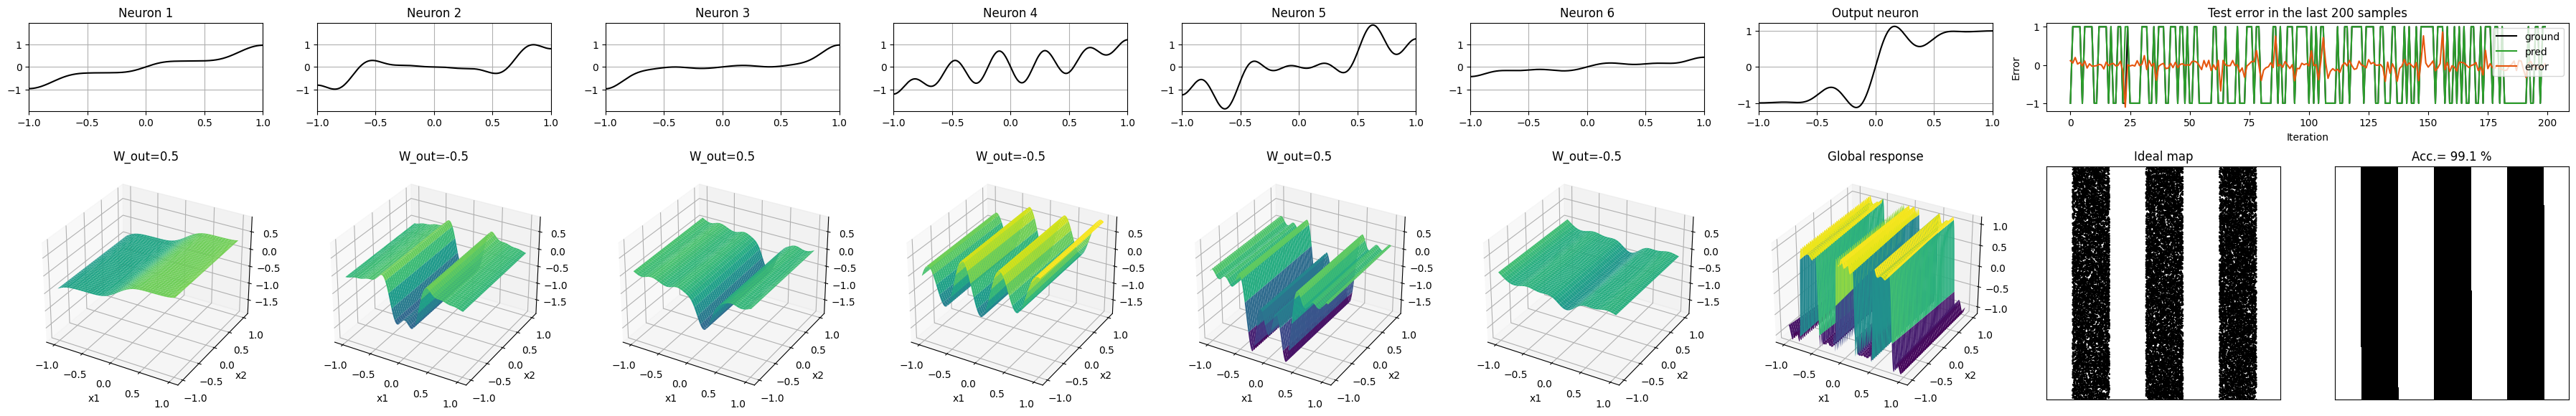

In [ ]:
n_input = 2        # Number of input variables
nft = 512          # Resolution for plots of DCT response
function = 8       # Select function
width = 6          # Number of neurons in the hidden layer
n_coeffs = 6       # Number of DCT coefficients per neuron
n_train = 400000   # Number of training samples.
n_test = 50000     # Number of test samples

lms = LMS()
data_train = Dataset(n_train, function)
data_test = Dataset(n_test, function)

enn = ENN(n_input, width, nft, n_coeffs)
error_train = enn.train(data_train, lms, verbose=True)
y_pred, error_test, metric = enn.test(data_test)

plot_results(enn, data_train, data_test, y_pred, error_train, error_test, metric)

This is another example:

Training ENN...
Sample 0 / 400000


<ipython-input-7-8851907977bd>:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  _, loss[i], x_proc = self.forward(x[:,[i]], y[i])


Sample 80000 / 400000
Sample 160000 / 400000
Sample 240000 / 400000
Sample 320000 / 400000
Testing ENN...


<ipython-input-7-8851907977bd>:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i], error[i], _ = self.forward(x[:,[i]], y[i])


Plotting results...


<ipython-input-9-aa64d8e8f6c0>:85: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i,j], _, _ = enn.forward(x_in[...,None], 0)


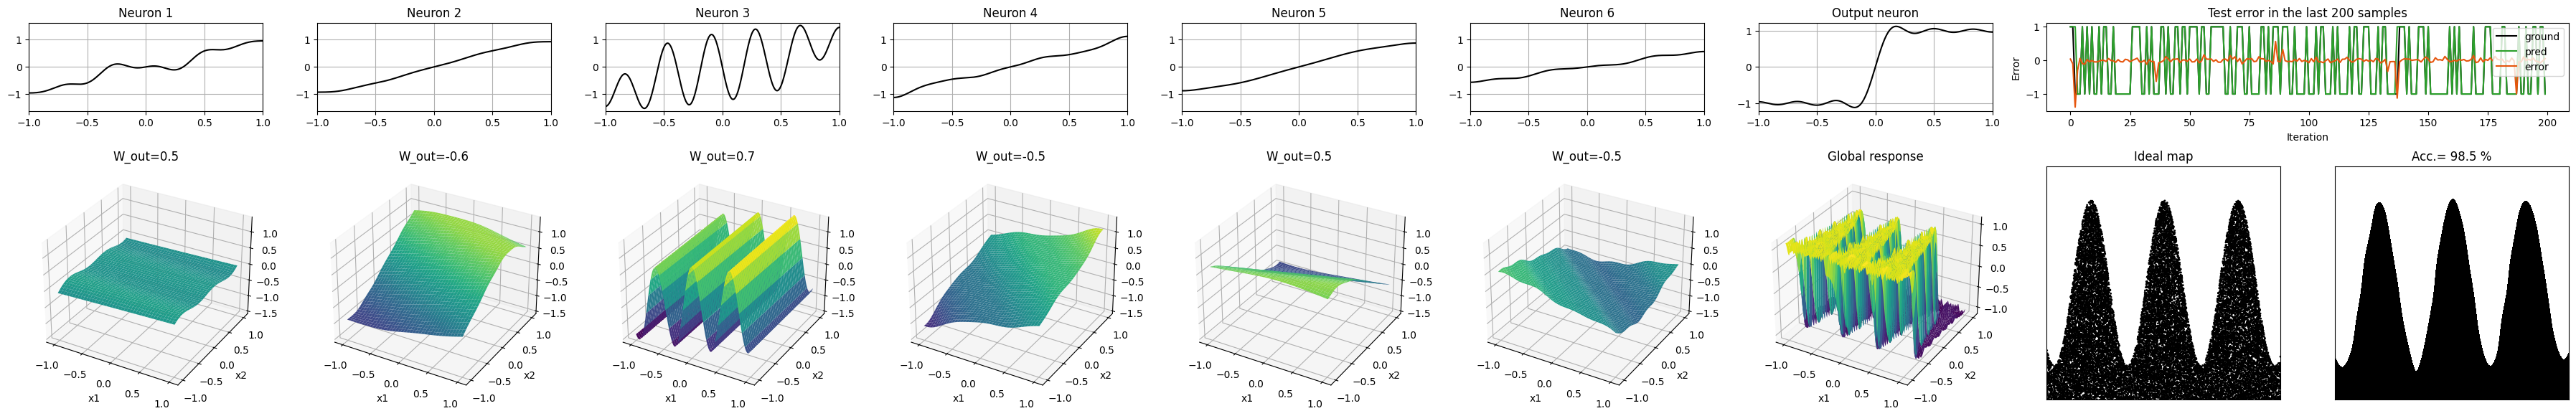

In [13]:
n_input = 2        # Number of input variables
nft = 512          # Resolution for plots of DCT response
function = 9       # Select function
width = 6          # Number of neurons in the hidden layer
n_coeffs = 6       # Number of DCT coefficients per neuron
n_train = 400000   # Number of training samples.
n_test = 50000     # Number of test samples

lms = LMS()
data_train = Dataset(n_train, function)
data_test = Dataset(n_test, function)

enn = ENN(n_input, width, nft, n_coeffs)
error_train = enn.train(data_train, lms, verbose=True)
y_pred, error_test, metric = enn.test(data_test)

plot_results(enn, data_test, y_pred, error_train, error_test, metric)

#### **Regression problems**

Standard multilayer perceptrons need to change the loss function as well as the output nonlinearity depending on the nature of the problem. However, the ENN trains both regression and classification problems with MSE. Notice how the activation function at the output layer is a step function for classification problems, while it converges to the identity function for regression problems.

Training ENN...
Sample 0 / 800000


<ipython-input-7-29482ab6c9a4>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  _, loss[i], x_proc = self.forward(x[:,[i]], y[i])


Sample 160000 / 800000
Sample 320000 / 800000
Sample 480000 / 800000
Sample 640000 / 800000
Testing ENN...


<ipython-input-7-29482ab6c9a4>:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i], error[i], _ = self.forward(x[:,[i]], y[i])


Plotting results...


<ipython-input-9-fa5f04f271d9>:85: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i,j], _, _ = enn.forward(x_in[...,None], 0)


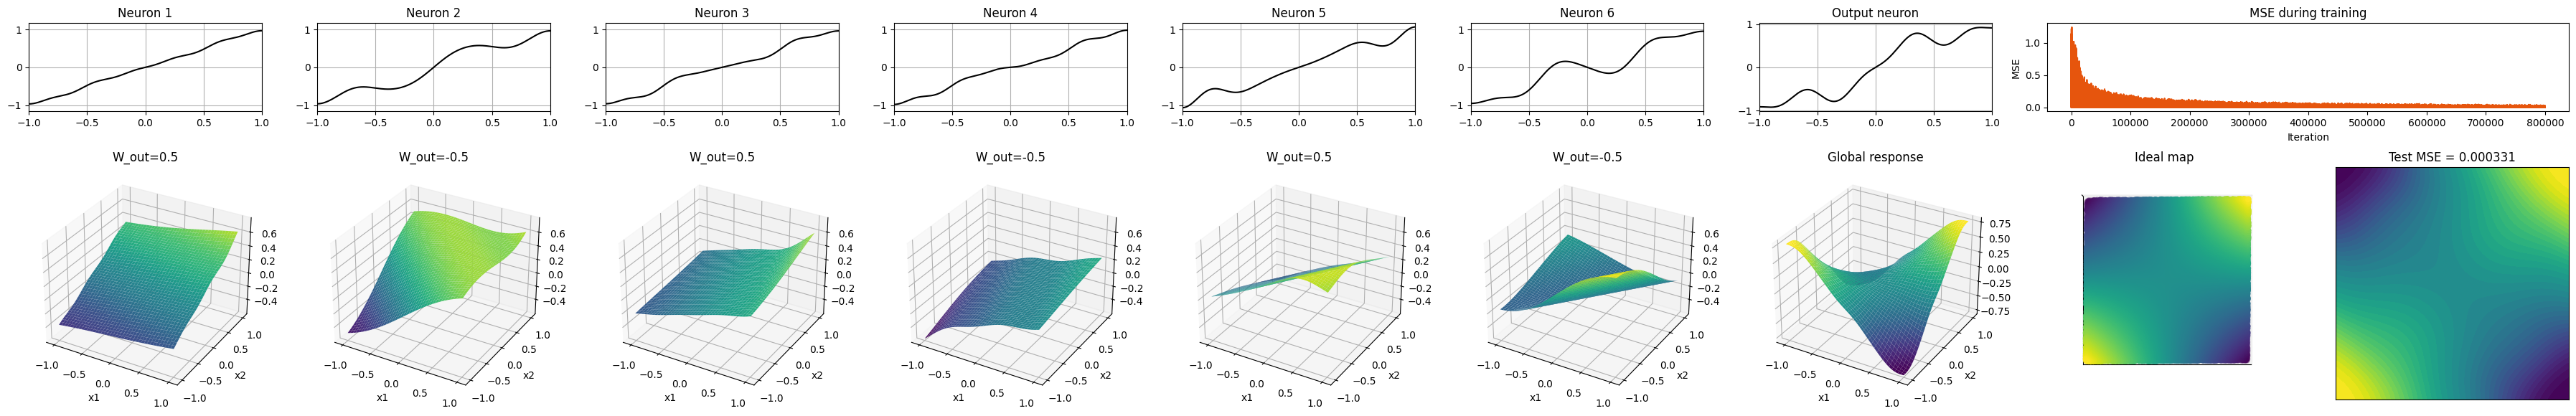

In [ ]:
n_input = 2        # Number of input variables
nft = 512          # Resolution for plots of DCT response
function = 14       # Select function
width = 6          # Number of neurons in the hidden layer
n_coeffs = 6       # Number of DCT coefficients per neuron
n_train = 800000   # Number of training samples.
n_test = 50000     # Number of test samples

lms = LMS()
data_train = Dataset(n_train, function)
data_test = Dataset(n_test, function)

enn = ENN(n_input, width, nft, n_coeffs)
error_train = enn.train(data_train, lms, verbose=True)
y_pred, error_test, metric = enn.test(data_test)

plot_results(enn, data_train, data_test, y_pred, error_train, error_test, metric)